In [1]:
WANDB_PROJECT = "mlops-course-001"
ENTITY = None # set this to team name if working in a team

BDD_CLASSES = {i: c for i,c in enumerate(['background', 'road', 'traffic light', 'traffic sign', 'person', 'vehicle', 'bicycle'])}
RAW_DATA_AT = 'bdd_simple_1k'
PROCESSED_DATA_AT = 'bdd_simple_1k_split'

In [2]:
!pip install wandb -qq
!pip install fastai

In [3]:
import os 
from pathlib import Path
from fastai.vision.all import untar_data

URL = 'https://storage.googleapis.com/wandb_course/bdd_simple_1k.zip'

path = Path(untar_data(URL, force_download=True))

In [4]:
path.ls()

(#3) [Path('/storage/d.berezin/.fastai/data/bdd_simple_1k/LICENSE.txt'),Path('/storage/d.berezin/.fastai/data/bdd_simple_1k/images'),Path('/storage/d.berezin/.fastai/data/bdd_simple_1k/labels')]

In [5]:
from fastai.vision.all import *

#get image files responsible for getting images from folder path
files = get_image_files(path/"images")
files

(#1000) [Path('/storage/d.berezin/.fastai/data/bdd_simple_1k/images/972ab49a-6a6eeaf5.jpg'),Path('/storage/d.berezin/.fastai/data/bdd_simple_1k/images/0a723d61-9885002e.jpg'),Path('/storage/d.berezin/.fastai/data/bdd_simple_1k/images/9c678386-81c3086d.jpg'),Path('/storage/d.berezin/.fastai/data/bdd_simple_1k/images/00aad4a0-ee8135fe.jpg'),Path('/storage/d.berezin/.fastai/data/bdd_simple_1k/images/80c62ee8-d23ec5b6.jpg'),Path('/storage/d.berezin/.fastai/data/bdd_simple_1k/images/099601d0-1b31f4ff.jpg'),Path('/storage/d.berezin/.fastai/data/bdd_simple_1k/images/772ac765-5f47e414.jpg'),Path('/storage/d.berezin/.fastai/data/bdd_simple_1k/images/a91b7555-00000100.jpg'),Path('/storage/d.berezin/.fastai/data/bdd_simple_1k/images/2224c461-351255b4.jpg'),Path('/storage/d.berezin/.fastai/data/bdd_simple_1k/images/346be4c0-c6743dbd.jpg')...]

In [6]:
#func for getting labels
def label_func(fname):
    return (fname.parent.parent/"labels")/f"{fname.stem}_mask.png"

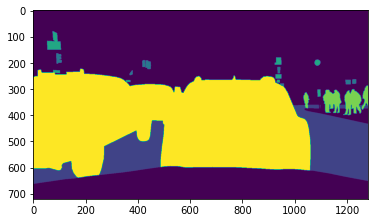

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

test_img = Image.open(label_func(files[2]))
plt.imshow(test_img)

In [8]:
np.array(test_img)[400, :]

array([5, 5, 5, ..., 0, 0, 0], dtype=uint8)

### We have 6 unique segmentations masks

In [9]:
list(np.unique(np.array(test_img)))

[0, 1, 2, 3, 4, 5]

In [10]:
BDD_CLASSES

{0: 'background',
 1: 'road',
 2: 'traffic light',
 3: 'traffic sign',
 4: 'person',
 5: 'vehicle',
 6: 'bicycle'}

In [11]:
import typing as tp

def get_classes_per_image(mask_data, class_labels) -> tp.Dict[str, int]:
    unique = list(np.unique(mask_data)) # count the number of labels in mask
    result_dict = {}
    
    for _class in class_labels.keys():
        if _class in unique:
            result_dict[class_labels[_class]] = 1
        else:
            result_dict[class_labels[_class]] = 0
        
    return result_dict

get_classes_per_image(np.array(test_img), BDD_CLASSES)

{'background': 1,
 'road': 1,
 'traffic light': 1,
 'traffic sign': 1,
 'person': 1,
 'vehicle': 1,
 'bicycle': 0}

In [12]:
[str(BDD_CLASSES[_lab]) for _lab in list(BDD_CLASSES)]

['background',
 'road',
 'traffic light',
 'traffic sign',
 'person',
 'vehicle',
 'bicycle']

In [13]:
list(BDD_CLASSES.values())

['background',
 'road',
 'traffic light',
 'traffic sign',
 'person',
 'vehicle',
 'bicycle']

In [14]:
??progress_bar

In [15]:
def _create_table(image_files, class_labels):
    labels = list(BDD_CLASSES.values()) #[str(class_labels[_lab]) for _lab in list(class_labels)]
    table = wandb.Table(columns=["File_Name","P1", "P2", "Images", "Split"] + labels)
    
    for i, image_file in progress_bar(enumerate(image_files), total=len(image_files)):
        image = Image.open(image_file)
        mask_data = np.array(Image.open(label_func(image_file)))
        
        class_in_image = get_classes_per_image(mask_data, class_labels) # dict
        table.add_data(
            str(image_file.name),
            image_file.stem.split('-')[0],
            image_file.stem.split('-')[1],
            wandb.Image(
                    image,
                    masks={
                        "predictions": {
                            "mask_data": mask_data,
                            "class_labels": class_labels,
                        }
                    }
            ),
            "None", # we don't have a dataset split yet
            *[class_in_image[_lab] for _lab in labels]
        )
    
    return table
     

In [16]:
import wandb

run = wandb.init(project=WANDB_PROJECT, job_type="upload")

# Create so called base
raw_data_at = wandb.Artifact('bdd_simple_1k_split', type="raw_data")

wandb: Currently logged in as: simmax21. Use `wandb login --relogin` to force relogin


In [17]:
raw_data_at.add_file(path/'LICENSE.txt', name='LICENSE.txt')

<ManifestEntry digest: X+6ZFkDOlnKesJCNt20yRg==>

In [18]:
raw_data_at.add_dir(path/'images', name='images')
raw_data_at.add_dir(path/'labels', name='labels')

wandb: Adding directory to artifact (/storage/d.berezin/.fastai/data/bdd_simple_1k/images)... Done. 0.4s
wandb: Adding directory to artifact (/storage/d.berezin/.fastai/data/bdd_simple_1k/labels)... Done. 0.5s


In [19]:
image_files = get_image_files(path/"images", recurse=False)

table = _create_table(image_files, BDD_CLASSES)

In [20]:
raw_data_at.add(table, "eda_table")

run.log_artifact(raw_data_at)
run.finish()